# 1. 背景说明

本例为利用 pytorch 神经网络完成对手写数字进行识别的示例。
主要步骤：
1. 利用 Pytorch 内置函数 mnist 下载数据；
2. 利用 torchvision 对数据进行预处理，调用 torc.utils 建立一个数据迭代器；
3. 可视化源数据；
4. 利用 nn 工具箱构建神经网络模型；
5. 实例化模型，并定义损失函数及优化器；
6. 训练模型；
7. 可视化结果。

# 2. 准备数据

## 2.1 导入必要的模块

In [24]:
import numpy as np
import torch
# 导入 PyTorch 内置的mnist 数据
from torchvision.datasets import mnist
# 导入预处理模块
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
# 导入 nn 及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

## 2.2 定义一些超参数

In [25]:
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epochs = 30
lr = 0.01
momentum = 0.5

## 2.3 下载数据并进行预处理

In [26]:
# 定义预处理函数，这些预处理依次放在 Compose 函数中
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
# 下载数据 并进行预处理
train_dataset = mnist.MNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST(root='../../data', train=False, transform=transform, download=True)
# dataloader 是一个可迭代对象
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

> 说明
1. transforms.Compose 可以把一些转换函数组合在一起；
2. Normalize((0.5,), (0.5,)) 对张量进行归一化，两个 0.5 分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的，只有一个通道，如果有多个通道，需要有多个数字，如3个通道，应该是 Normalize((m1, m2, m3), (n1, n2, n3)))；
3. download 参数控制是否需要下载；
4. 用 DataLoader 得到生成器，这可节省内存。

# 3. 可视化源数据

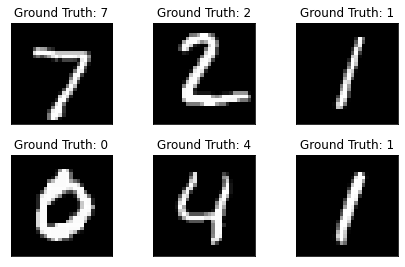

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# 4. 构建模型

> 数据预处理之后，开始构建网络，创建模型

## 4.1 构建网络

In [28]:
class Net(nn.Module):
    """
    使用 sequential 来定义网络， Sequential() 函数的功能是将网络的层组合到一起
    """

    def __init__(self, in_dim, out_dim, n_hidden_1, n_hidden_2):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

## 4.2 实例化网络

In [29]:
# 检测是否有可用的 GPU ，如果有，则使用 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net(28*28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# 5. 训练模型

**训练模型，这里使用for循环进行迭代。其中包括对训练数据的训练模型，然后用测试数据的进行验证的验证模型**

## 5.1 训练模型

In [30]:
# 开始训练
losses = []
access = []
eval_losses = []
eval_access = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch % 5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        output = model(img)
        loss = criterion(output, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = output.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    access.append(train_acc / len(train_loader))
    # 在测试集上评估模型
    eval_loss = 0
    eval_acc = 0
    # 切换到测试模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, label)
        # 记录误差
        eval_loss += loss.item()
        # 计算分类的准确率
        _, pred = output.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_access.append(eval_acc / len(test_loader))
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Eval Loss: {:.4f}, Eval Acc: {:.4f}'.format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), eval_loss / len(test_loader), eval_acc / len(test_loader)))

Epoch: 0, Train Loss: 4.6511, Train Acc: 0.3475, Eval Loss: 3.7426, Eval Acc: 0.6158
Epoch: 1, Train Loss: 2.8722, Train Acc: 0.6641, Eval Loss: 1.9234, Eval Acc: 0.7254
Epoch: 2, Train Loss: 1.3690, Train Acc: 0.7760, Eval Loss: 0.8506, Eval Acc: 0.8419
Epoch: 3, Train Loss: 0.6541, Train Acc: 0.9000, Eval Loss: 0.4369, Eval Acc: 0.9396
Epoch: 4, Train Loss: 0.3977, Train Acc: 0.9352, Eval Loss: 0.3065, Eval Acc: 0.9488
Epoch: 5, Train Loss: 0.3247, Train Acc: 0.9443, Eval Loss: 0.2942, Eval Acc: 0.9494
Epoch: 6, Train Loss: 0.3143, Train Acc: 0.9453, Eval Loss: 0.2854, Eval Acc: 0.9514
Epoch: 7, Train Loss: 0.3082, Train Acc: 0.9454, Eval Loss: 0.2801, Eval Acc: 0.9509
Epoch: 8, Train Loss: 0.2974, Train Acc: 0.9469, Eval Loss: 0.2708, Eval Acc: 0.9522
Epoch: 9, Train Loss: 0.2911, Train Acc: 0.9478, Eval Loss: 0.2680, Eval Acc: 0.9530
Epoch: 10, Train Loss: 0.2856, Train Acc: 0.9479, Eval Loss: 0.2638, Eval Acc: 0.9534
Epoch: 11, Train Loss: 0.2848, Train Acc: 0.9490, Eval Loss: 0.2

## 5.2 可视化训练及测试损失值

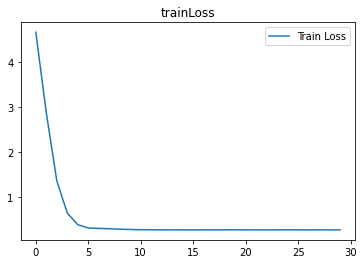

In [31]:
plt.title('trainLoss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')
plt.show()